In [86]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import math
import itertools

## Exercice : 1 Classification de texte avec le modèle Naive Bayes

In [2]:
from load_ag_news import load_ag_news
train_set, test_set = load_ag_news()

In [3]:
l = np.unique(np.array([x[0] for x in train_set]), return_counts=True)
def pi(i) :
    N = l[1].sum()
    Ni = l[1][l[0] == i].sum()
    return Ni/N

In [4]:
%timeit pi(1)

12.1 µs ± 562 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
d = {}

# Première boucle pour initialiser les valeurs des classes
for X, Y in train_set :
    if X in d:
        pass
    else:
        d[X]={}
        
for X, Y in train_set:
    for y in Y :
        if not(y in d[X]):
            d[X][y] = 1
        else :
            d[X][y] += 1

for k in d:
    s = sum(d[k].values())
    for word in d[k]:
        d[k][word] = d[k][word] / s

def b(i, yt):
    return d[i].get(yt, 0)

In [6]:
print(pi(1))
print(b(1, "London")) # Tout à fait exact

0.25
0.00018036294574312617


In [7]:
# Les versions classiques du Naive Bayes 

def p_i_s(i, s):
    """
    Return:
        - Probabilité que s appartienne à la classe i
    """
    e = 1e-5
    # Définition d'une fonction calculant la probabilité non normalisée que s appartiennent à la classe i
    def aux(i, s):
        p = pi(i)
        for word in s:
            p = p * (b(i, word) + e)
        return p

    den = 0
    for key in d:
        den += aux(key, s)
    
    return aux(i,s) / den # NB : pas utile de diviser car on compare les valeurs entre elles et x1 > x2 => x1/den > x2/den

def naive_bayes(s):
    """
    Prédit la classe de la phrase s
    Return
        Une classe de texte : 1, 2, 3 ou 4
    """
    d_res = {}
    for key in d:
        d_res[key] = p_i_s(key, s)
    return d_res, max(d_res, key = lambda x : d_res[x]) # On renvoie la valeur de la clé pour laquelle la probabilité est maximale
               

In [16]:
# Les versions log du Naive Bayes 

def aux_log(i, s, e):
    """
    Définition d'une fonction calculant la probabilité non normalisée que s appartiennent à la classe i
    avec un facteur de lissage e
    """
    
    p = np.log(pi(i))
    for word in s:
        p = p +(np.log(b(i, word) + e))
    return p

def p_i_s_log(i, s, e= 10e-5):
    """
    Return:
        - Probabilité (non normalisée) que s appartienne à la classe i
    """

    return aux_log(i,s, e) # NB : pas utile de diviser car on compare les valeurs entre elles et x1 > x2 => x1/den > x2/den

def naive_bayes_log(s, e= 10e-5):
    """
    Prédit la classe de la phrase s
    Return
        Une classe de texte : 1, 2, 3 ou 4
    """
    d_res = {}
    for key in [0,1,2,3]:
        d_res[key] = p_i_s_log(key, s, e)
    return max(d_res, key = lambda x : d_res[x]) # On renvoie la valeur de la clé pour laquelle la probabilité est maximale
                

In [17]:
# Phrase à prédire
naive_bayes(['Arsenal', 'is', 'a', 'londonian', 'team','.']) # Oui

({2: 0.0007448195290411271,
  3: 0.003928390804006227,
  1: 0.9924989725858532,
  0: 0.0028278170810995774},
 1)

In [10]:
# Prédiction sur l'ensemble du corpus
df_ag_test = pd.DataFrame(test_set, columns = ['classe', 'text']) # passage en dataframe pour calculer plus vite vectoriellement

In [11]:
def exactitude(a1, a2):
    return (a1==a2).sum()/len(a1)

In [14]:
%%time
for e in [1e-20,1e-10, 1e-5, 1]:
    score = exactitude(df_ag_test['text'].apply(lambda x : naive_bayes_log(x, e)), df_ag_test["classe"])
    print(f'Score pour e = {e}', np.round(score, 4))

Score pour e = 1e-20 0.8821
Score pour e = 1e-10 0.9011
Score pour e = 1e-05 0.8941
Score pour e = 1 0.4909
Wall time: 8.3 s


Sur les résultats demandés, plus e est petit meilleur est le résultat.
Il existe probablement un e* pour lequel le score est minimum avec e*>0. (c'est à dire qu'il y a une borne pour laquelle le score n'augmente plus en rapprochant e de 0)

## Exercice : 2 Etiquetage morpho-syntaxique avec CMC

In [2]:
from load_conll2000 import load_conll2000

In [3]:
path = r'C:\Users\Pierrick\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\IA702 - Modèles probabilistes et apprentissage automatique\TP3\TP3 functions-20211020\TP3_functions\\'
train_set, test_set = load_conll2000(path)

##### Estimation des paramètres :  pi(i), a_j(i) et b_i(y)

In [4]:
# Récupération des classes en présence dans train_set
l_classes = []
for x in train_set:
    for pair in x:
        l_classes.append(pair[0])
l_classes = np.array(l_classes)

In [5]:
a = np.unique(l_classes, return_counts = True)
d = dict(zip(a[0],a[1]))
N = sum(d.values())
for key in d :
    d[key] = {'nb' : d[key], 'perc' : d[key] / N}

In [6]:
s_perc = 0
for key in d:
    s_perc += d[key]["perc"]
print('Somme des pourcentages des classes à 1 : ', math.isclose(s_perc, 1.0))

Somme des pourcentages des classes à 1 :  True


In [47]:
GAMMA_X = list(d.keys())

In [50]:
def pi(i):
    """
    Renvoie la probabilité a priori de la classe 
    """
    if i not in GAMMA_X:
        raise ValueError(f"La classe demandée ({i}) n'appartient pas à GAMMA_X")
    return d[i]["perc"]

In [10]:
d_word = {}
for x in train_set:
    for pair in x:
        if pair[1] in d_word:
            if pair[0] in d_word[pair[1]]:
                d_word[pair[1]][pair[0]] += 1
            else : 
                d_word[pair[1]][pair[0]] = 1
        else :
            d_word[pair[1]] = {pair[0] : 1}
s = 0
for key in d_word:
    s += sum(d_word[key].values())
print("Contrôle du nombre de mots : ", s == N)

Contrôle du nombre de mots :  True


In [11]:
d_word

{'Confidence': {'NOUN': 1},
 'in': {'ADP': 3376, 'NOUN': 15, 'ADV': 7},
 'the': {'DET': 9202, 'ADP': 17},
 'pound': {'NOUN': 14},
 'is': {'VERB': 1412, 'NOUN': 3},
 'widely': {'ADV': 22},
 'expected': {'VERB': 114},
 'to': {'PART': 5045},
 'take': {'VERB': 100, 'NOUN': 1},
 'another': {'DET': 72},
 'sharp': {'ADJ': 21},
 'dive': {'NOUN': 3},
 'if': {'ADP': 193},
 'trade': {'NOUN': 36, 'VERB': 3},
 'figures': {'NOUN': 37, 'VERB': 5},
 'for': {'ADP': 1854, 'ADV': 2, 'ADJ': 1},
 'September': {'PROPN': 53},
 ',': {'PUNCT': 10770},
 'due': {'ADJ': 87},
 'release': {'NOUN': 7, 'VERB': 2},
 'tomorrow': {'NOUN': 8},
 'fail': {'VERB': 4},
 'show': {'VERB': 31, 'NOUN': 11},
 'a': {'DET': 4295},
 'substantial': {'ADJ': 18},
 'improvement': {'NOUN': 14},
 'from': {'ADP': 1045},
 'July': {'PROPN': 34},
 'and': {'CCONJ': 3578},
 'August': {'PROPN': 45},
 "'s": {'PART': 1638, 'VERB': 275, 'NOUN': 1},
 'near-record': {'ADJ': 2},
 'deficits': {'NOUN': 1},
 '.': {'PUNCT': 8725},
 'Chancellor': {'PROPN':

In [12]:
d_word_b_den = {}
for i in GAMMA_X :
    s = 0
    for word in d_word:
        s += d_word[word].get(i, 0)
    d_word_b_den[i] = s

{'ADJ': 14312,
 'ADP': 22847,
 'ADV': 7597,
 'CCONJ': 5372,
 'DET': 21261,
 'INTJ': 15,
 'NOUN': 43766,
 'NUM': 8315,
 'PART': 6850,
 'PRON': 4555,
 'PROPN': 20304,
 'PUNCT': 24223,
 'SYM': 1792,
 'VERB': 30480,
 'X': 38}

In [54]:
def b_old(i, y):
    """
    Permet de construire le dictionnaire d_b contenant toutes les valeurs des appels b(i, y)
    """
    if i not in GAMMA_X:
        raise ValueError(f"La classe demandée ({i}) n'appartient pas à GAMMA_X")  
    mot = d_word.get(y, 0)
    if mot == 0:
        return 0 
    return (d_word[y].get(i, 0)) / d_word_b_den[i]


# Initialisation de OMEGA_Y, l'ensemble des mots distincts du corpus train_set
omega_Y = set()
for x in train_set:
    for pair in x:
        if pair[1] not in omega_Y:
            omega_Y.add(pair[1])

d_b = {}
for i in GAMMA_X:
    d_b[i] = {}
    for j in omega_Y:
        d_b[i][j] = b_old(i,j)

def b(i, j):
    """
    Renvoie la probabilité d'avoir l'observation y sachant que X = i (i ~ lambda_i)
    Paramètre de lissage : 1e-5
    """
    if i not in GAMMA_X:
        raise ValueError(f"La classe demandée ({i}) n'appartient pas à GAMMA_X")
    res = d_b.get(i, 0)
    if res == 0:
        return 1e-5
    else :
        return res.get(j, 0) + 1e-5

0.36019485612847296


In [49]:
def a_old(i, j):
    """
    Fonction permettant de construire en dur un dictionnaire contenant les valeurs de a(i,j)
    """
    if (i, j) not in list(itertools.product(GAMMA_X,GAMMA_X)):
        raise ValueError(f"La classe demandée ({i}, {j}) n'appartient pas à GAMMA_X²")
    s1, s2 = (0, 0)
    for sent in train_set:
        n = len(sent)
        for k in range(n-1):
            if sent[k][0] == i:
                s2 += 1
                if sent[k+1][0] == j:
                    s1 += 1
    return s1/s2

d_a = {}
for i in GAMMA_X:
    d_a[i] = {}
    for j in GAMMA_X:
        d_a[i][j] = a_old(i,j)
        
def a(i, j):
    """
    Renvoie la probabilité a priori d'avoir X_t+1 = j sachant que X = i (i ~ lambda_i)
    """
    if (i, j) not in list(itertools.product(GAMMA_X,GAMMA_X)):
        raise ValueError(f"La classe demandée ({i}, {j}) n'appartient pas à GAMMA_X²")
    return d_a[i][j]

0.34821321140656963

In [55]:
# Vérification des valeurs
print(r"Sans paramètre de lissage : b_old('PUNCT', '.')", b_old('PUNCT', '.'))
print(r"b('PUNCT', '.') : ", b('PUNCT', '.'))
print(r"a('NUM', 'NOUN') : ", a('NUM', 'NOUN'))
print(r"pi('ADJ') : ", pi('ADJ'))

Sans paramètre de lissage : b_old('PUNCT', '.') 0.36019485612847296
b('PUNCT', '.') :  0.36020485612847297
a('NUM', 'NOUN') :  0.34821321140656963
pi('ADJ') :  0.06759648037331091


##### Algorithme forward-backward

Une première tentative faite en utilisant les formules par récurrence mais les temps de calcul sont trop longs

In [21]:
# Inititialisation
def alpha_1(i, Y):
    """
    Renvoie la valeur pour alpha_1(i) pour le Y donné
    """
    return pi(i) * b(i, Y[0])

def beta_T(i, Y):
    """
    Renvoie la valeur pour beta_T(i) pour le Y donné
    """
    return 1

alpha_1('NOUN', 'figures')

6.790159025537604e-06

In [22]:
def init_alpha(Y):
    l_alpha = []
    row = [alpha_1(x, Y) for x in GAMMA_X]
    l_alpha.append(row/sum(row))
    df_alpha = pd.DataFrame(l_alpha, columns = GAMMA_X)
    return df_alpha

def find_next_alpha(df_alpha, Y):   
    """
    Rajoute une ligne à df_alpha // calcul de alpha_t+1
    """
    
    ### OPTIMISATION
    ### find_next_alpha appelée len(Y)-1 fois
    
    
    row=[]
    t = len(df_alpha) - 1 # Le nombre d'étapes alpha calculées
    for i in GAMMA_X:
        s = 0
        for j in GAMMA_X:
            s += df_alpha[j][t] * a(j,i)  ## GAMMA_X² appels à la fonction a(j,i) | 30 ms par appel  -> priorité 1 à améliorer -> fait | 15 micros par appel
        alpha_new = b(i, Y[t+1]) * s  ## GAMMA_X appels à la fonction b   -> priorité 2 à améliorer
        row.append(alpha_new)
    df_alpha.loc[t+1] = row / sum(row)
    return df_alpha

def alpha(Y):
    """
    Renvoie la df_alpha complète pour Y
    """
    df_alpha = init_alpha(Y)
    for k in range(len(Y)-1):
        df_alpha = find_next_alpha(df_alpha, Y)
    return df_alpha

In [23]:
def init_beta(Y):
    l_beta = []
    row = np.array([1 for x in GAMMA_X])
    l_beta.append(row/sum(row))
    df_beta = pd.DataFrame(l_beta, columns = GAMMA_X)
    return df_beta

def find_next_beta(df_beta, Y):
    row=[]
    t = len(df_beta) - 1 # Le nombre d'étapes alpha calculées
    for i in GAMMA_X:
        s = 0
        for j in GAMMA_X:
            s += df_beta[j][t] * a(i, j) * b(j, Y[t])  # GAMMA_X² appels à b pas optimisée | 5ms par appel
        row.append(s)
    df_beta.loc[t+1] = row / sum(row)
    return df_beta

def beta(Y):
    """
    Renvoie la df_beta complète pour Y
    """
    df_beta = init_beta(Y)
    for k in range(len(Y)-1):
        df_beta = find_next_beta(df_beta, Y)
    return df_beta.sort_index(ascending = False).reset_index()

In [24]:
def p(t, i, Y, df_alpha, df_beta):
    """
    Renvoie la probabilité de X_t = i sachant Y
    Utilise : les dataframes calculées pour alpha et beta
    """
    s = 0
    for j in GAMMA_X:
        s += df_alpha[j][t] * df_beta[j][t]
    return (df_alpha[i][t] * df_beta[i][t]) / s

In [25]:
def predict_X_t(t, Y, df_alpha, df_beta):
    """
    Renvoie la prédiction pour la classe de X_t en ayant observé Y
    Utilise : les dataframes calculées pour alpha et beta
    """
    res = None
    proba = 0
    for i in GAMMA_X:
        if p(t, i, Y, df_alpha, df_beta)>proba:
            proba = p(t, i, Y, df_alpha, df_beta)
            res = i
    return res

In [26]:
def predict_x(Y):
    """
    Renvoie une liste de prédictions pour chaque mot de Y, à valeur dans GAMMA_X
    Utilise : les dataframes calculées pour alpha et beta
    """
    df_alpha = alpha(Y)
    df_beta = beta(Y)
    res= []
    for t in range(len(Y)):
        res.append(predict_X_t(t, Y, df_alpha, df_beta))
    return res

In [27]:
# Test sur la phrase donnée comme exemple
Y = ["I", "am", "a", "student", "in", "a", "French", "school","."]
predict_x(Y)

['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']

In [28]:
# Récupération des labels en présence dans test_set
labels_test = []
for x in test_set:
    for pair in x:
        labels_test.append(pair[0])
labels_test = np.array(labels_test)
labels_test

array(['PROPN', 'PROPN', 'PROPN', ..., 'PROPN', 'PROPN', 'PUNCT'],
      dtype='<U5')

In [45]:
# # Récupération des phrase du test_set -> désactivé car sauvegardé au format pickle

# phrases_test = []
# for x in test_set:
#     phrase = [y[1] for y in x]
#     phrases_test.append(phrase)

# labels_predict = list(map(predict_x,phrases_test))
# labels_predict_flat = []
# for sublist in labels_predict:
#     for prediction in sublist:
#         labels_predict_flat.append(prediction)
# labels_predict_flat = np.array(labels_predict_flat)   


# Sauvegarde au format pickle

import pickle
with open('mypicklefile', 'wb') as prediction_test:
    pickle.dump(labels_predict_flat, prediction_test)
with open('mypicklefile', 'rb') as prediction_test:
    labels_predict_flat = pickle.load(prediction_test)

In [46]:
print("Pourcentage de mots bien labellisés : ")
round((labels_test[:len(labels_predict_flat)] == labels_predict_flat).sum() / len(labels_predict_flat), 8)*100

Pourcentage de mots bien labellisés : 


90.76134

## Exercice : 3 Filtrage de Kalman

In [84]:
from scipy.ndimage.interpolation import shift

In [63]:
path = r"C:\Users\Pierrick\OneDrive\Bureau\K\2_MS_TelecomParis\Cours\IA702 - Modèles probabilistes et apprentissage automatique\TP3\TP3 functions-20211020\TP3_functions\\"
X = np.loadtxt(path + "signal_X.txt")
Y = np.loadtxt(path + "signal_Y.txt")

### 1) Estimation des paramètres a et b de manière non supervisée

On utilise 
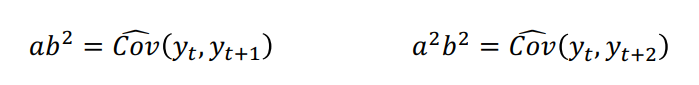


En notant $ab^2 = w_1$ et $a^2b^2=w_2$, on a:


$a = \frac{w_2}{w_1}$

et

$b = \sqrt \frac{w_1^2}{w_2}$

Calcul de $w_1 = ab^2$

In [151]:
y_mean = Y.mean()
y_shifted_1 = shift(Y, 1, cval=np.NaN)[1:]
w1 = ((Y-y_mean)[1:] * (y_shifted_1 - y_shifted_1.mean())).sum() / len(y_shifted_1)
w1

0.4679480353869944

Calcul de $w_2 = a^2b^2$

In [152]:
y_shifted_2 = shift(Y, 2, cval=np.NaN)[2:]
w2 = ((Y-y_mean)[2:] * (y_shifted_2 - y_shifted_2.mean())).sum() / len(y_shifted_2)
w2

0.2790016315967287

Calcul de a et b

In [156]:
a = w2/w1
b = w1 /np.sqrt(w2)
print("a : " , a)
print("b : " , b)

a :  0.5962235344486349
b :  0.8859194912700463


### 2) Filtre de Kalman

#### 2.1) Calcul de la première position (initialisation)

In [223]:
x = [b * Y[0]]
sigma = [1 - b**2]
x, sigma

([0.04618364913740982], [0.21514665498782237])

#### 2.2)  Calcul récursif (hérédité)

In [194]:
t = 0

In [195]:
# Etape 1
sigma_temp = 1 - a**2 + a**2 * sigma[-1]
x_temp = a * x[-1]
# sigma_temp, x_temp

In [196]:
# Etape 2
y_temp = Y[t+1] - b * x_temp
S = b * sigma_temp + 1 - b**2
y_temp, S

(2.560537870158251, 0.8538931627301819)

In [197]:
# Etape 3
K = b / S * sigma_temp
K

0.748040311858305

In [198]:
# Etape 4
x_new = x_temp + K * y_temp
sigma_new = (1 - b * K) * sigma_temp
x_new, sigma_new

(1.9429213254406201, 0.24319023155327346)

In [266]:
def iter_Kalman(x, sigma, Y, a, b):
    """
    Renvoie deux nouvelles listes x_new et sigma_new contenant une itération de plus pour la restauration de x
    
    Args :
        - x et sigma sont des listes qui contiennent les valeurs calculées pour la loi restaurée (leur longueur est l'étape en cours)
        - Y le signal observé
        - a et b deux paramètres calculés grâce à Y (fixés)
    """
    t = len(x)-1
    
    # Etape 1
    sigma_temp = 1 - a**2 + a**2 * sigma[-1]
    x_temp = a * x[-1]
    
    # Etape 2
    y_temp = Y[t+1] - b * x_temp
    S = b**2 * sigma_temp + 1 - b**2
    
    # Etape 3
    K = b / S * sigma_temp
    
    # Etape 4
    x_new = x_temp + K * y_temp
    sigma_new = (1 - b * K) * sigma_temp
    
    # Actualisation de la liste avec la nouvelle valeur
    res_x = x.copy()
    res_x.append(x_new)
    res_y = sigma.copy()
    res_y.append(sigma_new)
    
    return res_x, res_y 

In [267]:
def Kalman(Y, a, b):
    x = [b * Y[0]]
    sigma = [1 - b**2]
    
    for i in range(len(Y)-1):
        x, sigma = iter_Kalman(x, sigma, Y, a, b)
    
    return x, sigma

In [268]:
x, sigma = Kalman(Y, a, b)

### 3) Evaluation du filtre de Kalman

In [269]:
def EQM(x, y):
    """
    Revoie l'erreur quadratique moyenne entre deux vecteurs x et y de dimension 1 et de même taille
    """
    if len(x)!= len(y):
        raise ValueError("x et y n'ont pas la même taille")
    
    T = len(x)
    s = 0
    for i in range(T):
        s += (x[i]-y[i])**2
    return s / T

In [270]:
EQM(x, X)

0.17449618163934927

In [271]:
EQM(Y, X)

0.20225719834189304

Le signal restauré est plus proche du signal réel (au sens de l'EQM) que le signal observé, le filtrage fonctionne !

### 4) Affichage graphique

Text(0, 0.5, 'Altitude')

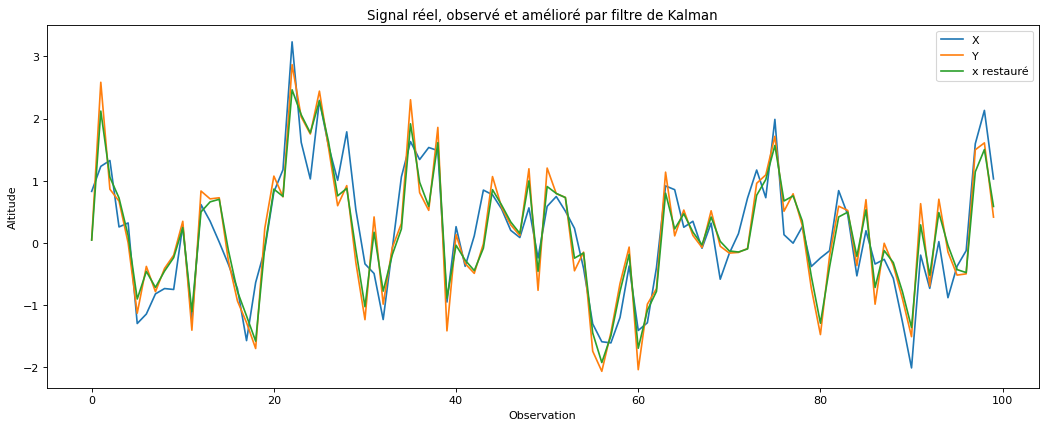

In [272]:
plt.figure(figsize=(16, 6), dpi=80)
plt.plot(X[:100], label = 'X')
plt.plot(Y[:100], label = 'Y')
plt.plot(x[:100], label = 'x restauré')
plt.legend()
plt.title("Signal réel, observé et amélioré par filtre de Kalman")
plt.xlabel("Observation")
plt.ylabel("Altitude")